In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import fetch_weather
import fetch_consumption
import datetime
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

/home/sakorpi/.conda/envs/conda-ml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load model and data for future

In [2]:
model = XGBRegressor()
model.load_model('../models/xgboost_model.ubj')

wind = pd.read_parquet('../future_data/wind.parquet')
consumption = pd.read_parquet('../future_data/consumption.parquet')
weather = pd.read_parquet('../future_data/weather.parquet')

df = wind.join(consumption).join(weather).tz_localize(tz='UTC')
df.tail()


,Wind_MWh,w_lag1,w_lag2,w_lag3,Consumption_MWh,c_lag1,c_lag2,c_lag3,pressure,rain,...,rain_lag3,hum_lag1,hum_lag2,hum_lag3,temp_lag1,temp_lag2,temp_lag3,win_lag1,win_lag2,win_lag3
2022-12-31 20:00:00+00:00,1641.641724,878.0,561.0,NaN,11641.276367,11561.0,10490.0,NaN,1016.277466,0.137756,...,0.0,93.0,96.0,69.0,-9.5,-1.6,1.2,4.3,4.7,6.7
2022-12-31 21:00:00+00:00,1566.043701,703.0,583.0,NaN,11217.675781,11497.0,10318.0,NaN,1019.209839,0.137756,...,0.0,93.0,95.0,71.0,-9.9,-1.8,0.7,4.2,5.2,4.8
2022-12-31 22:00:00+00:00,951.898865,512.0,572.0,1597.0,10164.972656,11075.0,9914.0,9950.0,1011.546509,0.137756,...,0.0,92.0,95.0,69.0,-10.6,-1.9,0.1,4.5,5.0,6.0
2022-12-31 23:00:00+00:00,1354.330811,463.0,538.0,1514.0,10246.028320,10724.0,9535.0,9610.0,1010.478638,0.128011,...,0.0,92.0,94.0,65.0,-11.0,-2.2,-0.3,2.7,4.3,5.6
2023-01-01 00:00:00+00:00,1078.862183,601.0,547.0,1386.0,9447.356445,10473.0,9296.0,9408.0,1011.432007,0.041001,...,0.0,91.0,94.0,61.0,-10.1,-2.3,-0.5,3.4,4.0,6.3


#### Get fresh data and merge it on top the old/future data
This can also be skipped. Just comment the cell below and the prediction is done without fresh data.
If there is problem when fetching, the result will be None and df cannot be updated but then the step is automatically skipped.

In [3]:
#fetch 7 days weather history + 2 days forecast
weather_fetched = fetch_weather.get_7days_and_forecast_2days()
#fetch 14 days consumption history
consumption_fetched = fetch_consumption.get_consumption_trimmed(datetime.datetime.now()-datetime.timedelta(days=14), datetime.datetime.now())
df.update(weather_fetched)
df.update(consumption_fetched)

#### Helper function to add time series features

In [5]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [6]:
def get_recommendation(x):
    if x > 1.3:
        return '-'
    elif x < -0.7:
        return '+'
    else:
        return '0'

### Predict the future!

In [7]:
NUMBER_OF_DAYS_TO_PREDICT = 30
SMA_WINDOW = 168 # Window size for simple moving average

In [8]:
now_ceil = pd.Timestamp.now(tz='UTC').ceil(freq='H')
date_range = pd.date_range(
        start=now_ceil-timedelta(hours=SMA_WINDOW), end=now_ceil+timedelta(days=NUMBER_OF_DAYS_TO_PREDICT), freq="H")
future_df = pd.DataFrame({'datetime': date_range}).set_index('datetime')
future_df = future_df.join(df)
future_df = create_features(future_df)


In [9]:
features = ['Wind_MWh','Consumption_MWh','pressure','rain','humidity','temperature','wind',
            'dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'c_lag1','c_lag2','c_lag3','w_lag1','w_lag2','w_lag3','pr_lag1','pr_lag2','pr_lag3',
            'rain_lag1','rain_lag2','rain_lag3','hum_lag1','hum_lag2','hum_lag3',
            'temp_lag1','temp_lag2','temp_lag3','win_lag1','win_lag2','win_lag3'] # These should be the same as used in modelling!!!
future_df['price'] = model.predict(future_df[features])

# Plot the price for the future!

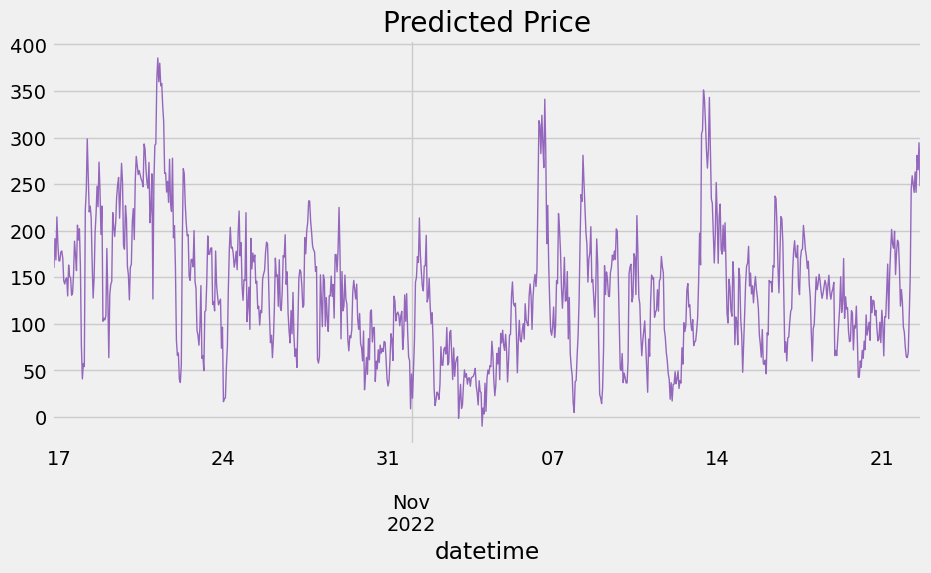

In [10]:
future_df['price'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Predicted Price')
plt.show()

### Calculate SMA and price index

In [11]:
future_df['SMA'] = future_df['price'].rolling(SMA_WINDOW).mean()
future_df['value'] = future_df['price'] / future_df['SMA']
future_df['recommendation'] = future_df['value'].apply(
    get_recommendation)
RETURNED_FEATURES = ['value', 'recommendation']
future_df = future_df[now_ceil:][RETURNED_FEATURES].reset_index()
future_df

,datetime,value,recommendation
0,2022-10-23 17:00:00+00:00,0.741797,0
1,2022-10-23 18:00:00+00:00,0.680902,0
2,2022-10-23 19:00:00+00:00,0.632395,0
3,2022-10-23 20:00:00+00:00,0.650906,0
4,2022-10-23 21:00:00+00:00,0.666919,0
...,...,...,...
716,2022-11-22 13:00:00+00:00,2.045624,-
717,2022-11-22 14:00:00+00:00,2.252315,-
718,2022-11-22 15:00:00+00:00,1.890103,-
719,2022-11-22 16:00:00+00:00,2.374558,-
